In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install --upgrade seaborn pandas
import warnings

In [11]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated and will be removed in a future version",
    category=FutureWarning
)

### 0. Inputs

In [12]:
# 1) Define an explicit color palette as a dict with regime -> (R, G, B) tuples
colorpalette = {
    'Recession':  (215/250, 48/250, 48/250),  # pure red
    'Slowdown':   (239/250, 123/250, 90/250),  # orange-ish
    'Recovery':   (0/250, 145/250, 90/250),  # darker green
    'Expansion':  (86/255, 180/255, 192/255),  # pure blue
}

### 1. Fake data - Macro regime and vols levels

In [13]:
def generate_macro_regime_dates(start_date='2020-01-01', end_date='2021-12-31'):
    """
    Generate a DataFrame named macro_regime_dates where each date
    is assigned a macro regime based on date intervals.
    """
    import pandas as pd

    # Create all dates between start and end (daily frequency)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize an empty DataFrame
    macro_regime_dates = pd.DataFrame(index=dates, columns=['regime'])

    # Assign regimes by date boundaries
    macro_regime_dates.loc['2020-01-01':'2020-03-31', 'regime'] = 'Recession'
    macro_regime_dates.loc['2020-04-01':'2020-09-30', 'regime'] = 'Slowdown'
    macro_regime_dates.loc['2020-10-01':'2021-03-31', 'regime'] = 'Recovery'
    macro_regime_dates.loc['2021-04-01':'2021-12-31', 'regime'] = 'Expansion'
    
    return macro_regime_dates


def generate_raw_data(start_date='2020-01-01', end_date='2021-12-31'):
    """
    Generate a synthetic DataFrame named raw_data.
    The DataFrame is indexed by dates, with columns:
      - spot
      - vol_1m
      - rv_1m
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n = len(dates)
    
    # Synthetic time series (replace with real data loading in production)
    spot = 100 + np.cumsum(np.random.normal(loc=0, scale=1, size=n))
    vol_1m = np.random.normal(loc=20, scale=3, size=n).clip(min=0)    # vol can't be negative
    rv_1m = np.random.normal(loc=15, scale=2, size=n).clip(min=0)     # realized vol can't be negative
    
    raw_data = pd.DataFrame(
        index=dates,
        data={
            'spot': spot,
            'vol_1m': vol_1m,
            'rv_1m': rv_1m
        }
    )
    return raw_data

#### 2. Compute perf - Returns and vols shifts

In [14]:
def calc_performance(df, col_name='spot', performance_type='return'):
    """
    Calculate performance from a given price or series column.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least one column (e.g. 'spot') 
        to calculate returns or shifts.
    col_name : str
        The column in 'df' on which to perform the calculation.
    performance_type : str
        - 'return':  calculates percentage change 
                     (df[col_name].pct_change())
        - 'shift':   calculates absolute shift 
                     (df[col_name].diff())
    
    Returns
    -------
    pd.Series
        The performance series as either a percentage return or a shift.
    """
    if performance_type == 'return':
        # Percentage return
        return df[col_name].pct_change().fillna(0)
    elif performance_type == 'shift':
        # Absolute shift
        return df[col_name].diff().fillna(0)
    else:
        raise ValueError("performance_type must be one of ['return', 'shift']")

### 3. Prepare data

In [15]:
def prepare_plot_data(raw_data, macro_regime_dates, performance_series, performance_label="Performance"):
    """
    1) Merge raw_data with macro_regime_dates on the date index.
    2) Insert a new column (performance_label) into the merged DataFrame.
    3) Replace ±inf with NaN, then drop rows that have NaN in key columns.
    
    Returns
    -------
    pd.DataFrame
        A cleaned, merged DataFrame ready for plotting. 
        Expects 'regime' column (categorical) and performance_label column.
    """
    # Merge
    merged_df = raw_data.join(macro_regime_dates, how='inner').copy()
    merged_df[performance_label] = performance_series

    # Replace ±inf with NaN, then drop them
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(axis=0, how='any', subset=[performance_label, 'vol_1m', 'regime'], inplace=True)
    
    return merged_df




#### 4. Plot 

In [16]:
def plot_regime_distributions(merged_df, performance_label="Performance"):
    """
    Create a 2×2 grid of histograms for each unique regime in merged_df['regime'].
    Remove top/right spines, place axes at (0,0), and use our colorpalette dict.
    """
    regimes = merged_df['regime'].unique()
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for i, regime_name in enumerate(regimes):
        subset = merged_df[merged_df['regime'] == regime_name]
        
        # Regime-specific color
        this_color = colorpalette.get(regime_name, (0.3, 0.3, 0.3))  # default gray
        
        sns.histplot(
            data=subset,
            x=performance_label,
            ax=axes[i],
            kde=True,
            color=this_color,
            alpha=0.7
        )
        axes[i].set_title(f"{regime_name} - {performance_label} distribution", pad=10)
        axes[i].set_xlabel(performance_label)
        
        # Remove top/right spines
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        
        # Move left/bottom spines to x=0, y=0
        axes[i].spines['left'].set_position(('data', 0))
        axes[i].spines['bottom'].set_position(('data', 0))
        
        # Draw lines at x=0 and y=0
        axes[i].axhline(0, color='black', linewidth=1)
        axes[i].axvline(0, color='black', linewidth=1)

    plt.tight_layout()
    plt.show()


def plot_regime_scatter(merged_df, performance_label="Performance"):
    """
    Create a scatter plot of performance_label vs 'vol_1m', 
    colored by 'regime' using our colorpalette dict.
    Remove top/right spines and place axes at (0,0).
    """
    plt.figure(figsize=(8, 6))
    scatter_ax = sns.scatterplot(
        data=merged_df,
        x=performance_label,
        y='vol_1m',
        hue='regime',
        palette=colorpalette,
        alpha=0.8,
        edgecolor='black'
    )
    scatter_ax.set_title(f"{performance_label} vs. vol_1m by regime", pad=10)
    scatter_ax.set_xlabel(performance_label)
    scatter_ax.set_ylabel("vol_1m")

    # Remove top/right spines
    scatter_ax.spines['top'].set_visible(False)
    scatter_ax.spines['right'].set_visible(False)

    # Move left/bottom spines to x=0, y=0
    scatter_ax.spines['left'].set_position(('data', 0))
    scatter_ax.spines['bottom'].set_position(('data', 0))

    # Draw lines at x=0 and y=0
    scatter_ax.axhline(0, color='black', linewidth=1)
    scatter_ax.axvline(0, color='black', linewidth=1)

    plt.legend(title='Regime', loc='best')
    plt.show()

### Inpsect data

In [17]:
macro_regime_dates

,regime
2020-01-01,Recession
2020-01-02,Recession
2020-01-03,Recession
2020-01-04,Recession
2020-01-05,Recession
...,...
2021-12-27,Expansion
2021-12-28,Expansion
2021-12-29,Expansion
2021-12-30,Expansion


In [18]:
raw_data

,spot,vol_1m,rv_1m
2020-01-01,100.459765,16.731538,15.136875
2020-01-02,102.399651,14.071855,12.913849
2020-01-03,101.073034,18.210127,17.683876
2020-01-04,99.573676,21.166802,15.138086
2020-01-05,101.993030,22.068632,16.556084
...,...,...,...
2021-12-27,131.124139,22.358522,14.993826
2021-12-28,131.958307,23.326928,15.504655
2021-12-29,132.826150,21.116788,13.601999
2021-12-30,131.707851,25.460444,14.093865


In [28]:
if __name__ == "__main__":
    # 1) Generate the macro regime dates and raw data
    macro_regime_dates = generate_macro_regime_dates()
    raw_data = generate_raw_data()
    
    # Print raw data
    print("=== RAW DATA ===")
    print(raw_data)
    
    # 2) Calculate all performance series
    performance_return = calc_performance(raw_data, col_name='spot',   performance_type='return')
    performance_shift_vol = calc_performance(raw_data, col_name='vol_1m', performance_type='shift')
    performance_shift_rv  = calc_performance(raw_data, col_name='rv_1m',  performance_type='shift')

    # --- Analysis 1: Spot Return ---
    spot_return_df = prepare_plot_data(
        raw_data, 
        macro_regime_dates, 
        performance_return, 
        performance_label="Spot_Return"
    )
    print("\n=== SPOT RETURN MERGED DATA ===")
    print(spot_return_df)

    # --- Analysis 2: Vol Shift ---
    shift_vol_df = prepare_plot_data(
        raw_data, 
        macro_regime_dates, 
        performance_shift_vol,
        performance_label="Shift_Vol"
    )
    print("\n=== VOL SHIFT MERGED DATA ===")
    print(shift_vol_df)

    # --- Analysis 3: RV Shift ---
    shift_rv_df = prepare_plot_data(
        raw_data, 
        macro_regime_dates, 
        performance_shift_rv,
        performance_label="Shift_RV"
    )
    print("\n=== RV SHIFT MERGED DATA ===")
    print(shift_rv_df)

=== RAW DATA ===
                  spot     vol_1m      rv_1m
2020-01-01   98.477545  24.593055  17.379304
2020-01-02   98.428919  18.329403  19.309288
2020-01-03   97.630941  26.430155  12.899527
2020-01-04   98.243591  12.555529  12.256654
2020-01-05   98.172685  19.913203  10.544810
...                ...        ...        ...
2021-12-27  100.700723  20.476324  11.224572
2021-12-28  101.352477  15.370650  13.498564
2021-12-29  102.261500  17.114482  17.308709
2021-12-30  102.767717  23.166480  15.602686
2021-12-31  101.213214  23.520733  19.238888

[731 rows x 3 columns]

=== SPOT RETURN MERGED DATA ===
                  spot     vol_1m      rv_1m     regime  Spot_Return
2020-01-01   98.477545  24.593055  17.379304  Recession     0.000000
2020-01-02   98.428919  18.329403  19.309288  Recession    -0.000494
2020-01-03   97.630941  26.430155  12.899527  Recession    -0.008107
2020-01-04   98.243591  12.555529  12.256654  Recession     0.006275
2020-01-05   98.172685  19.913203  10.544

### Run all

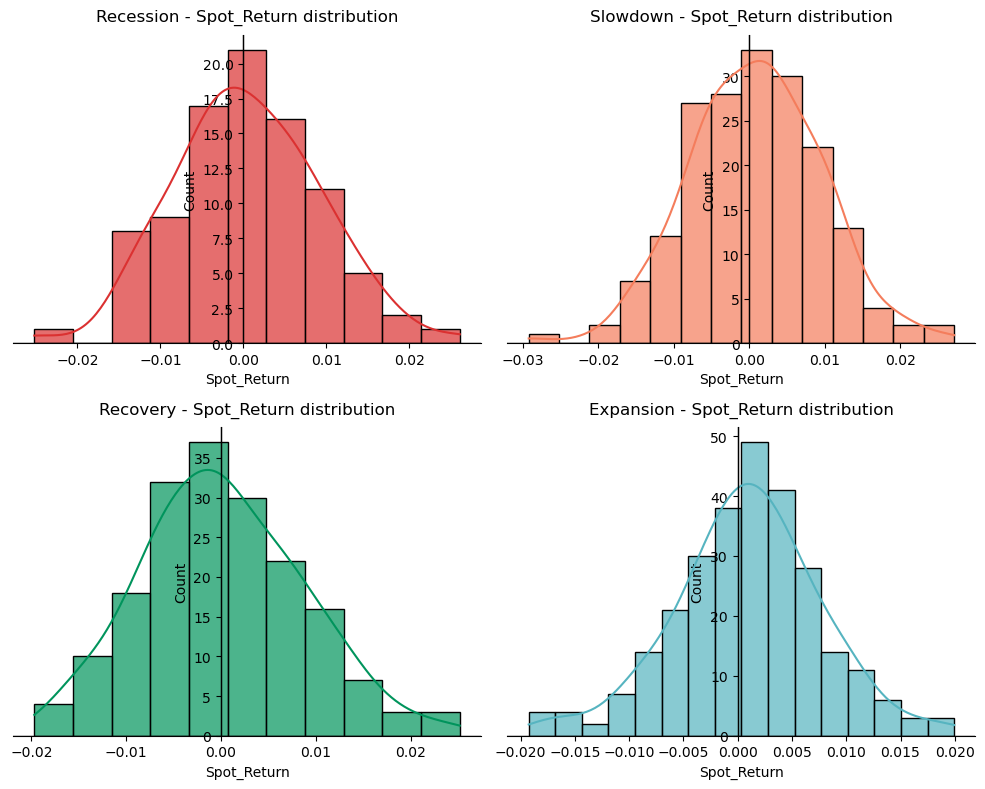

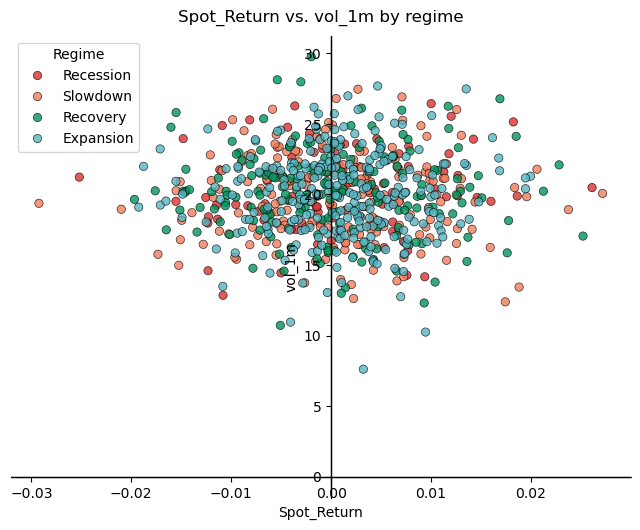

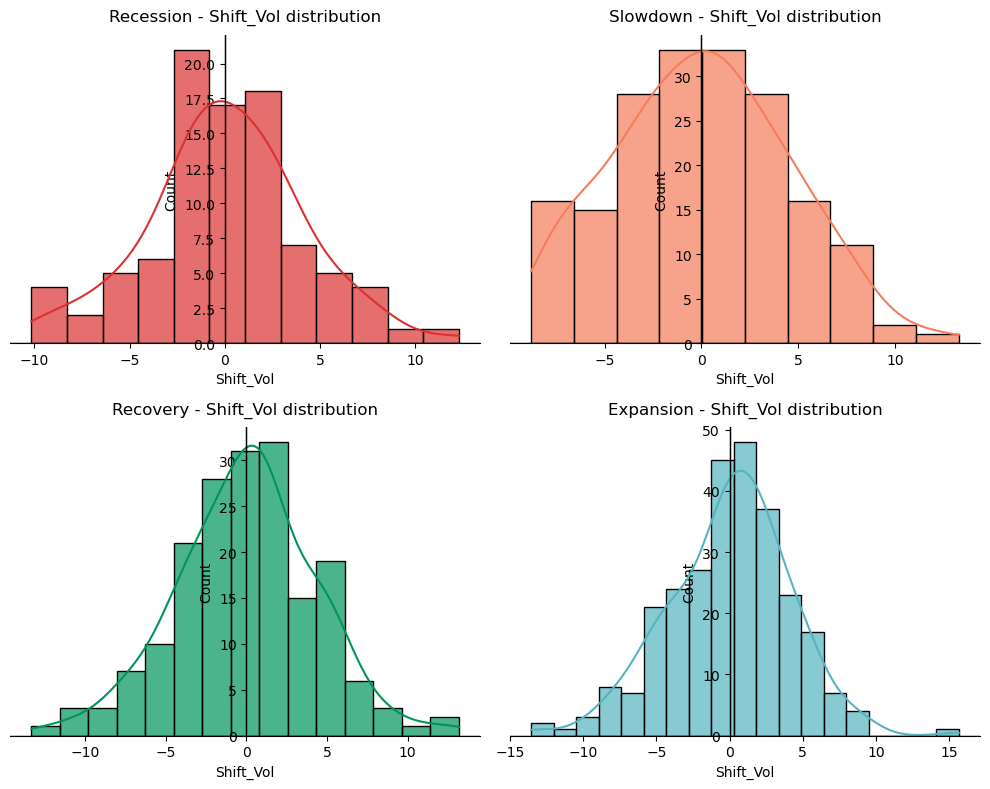

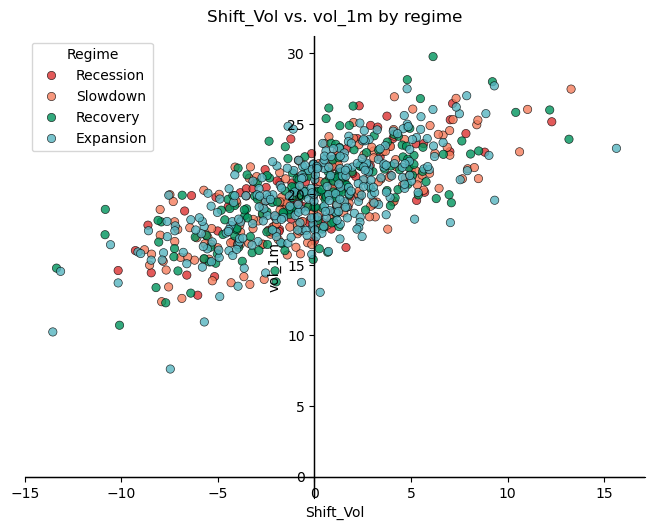

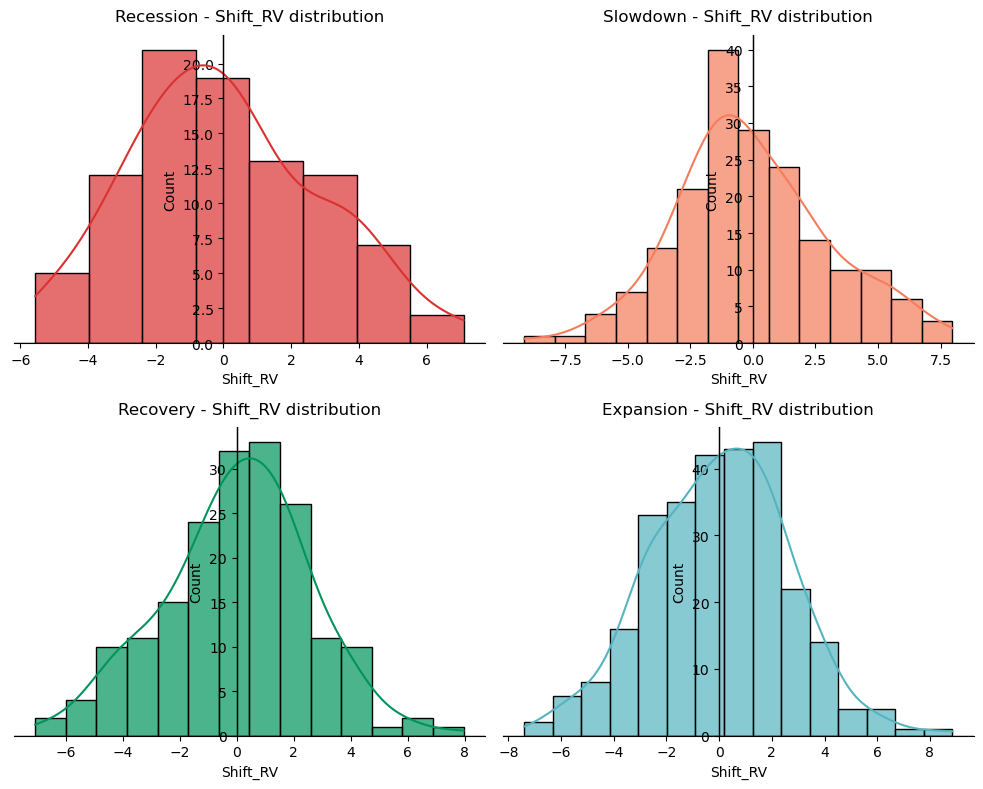

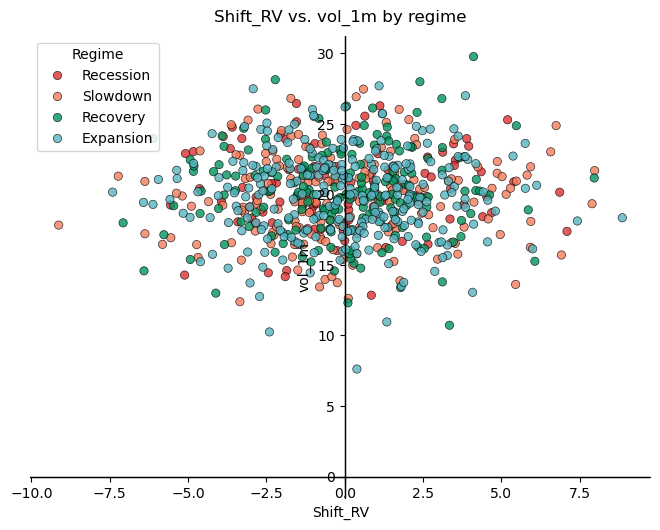

In [23]:
if __name__ == "__main__":
    # 1) Generate the macro regime dates and raw data
    macro_regime_dates = generate_macro_regime_dates()
    raw_data = generate_raw_data()

    # 2) Calculate all performance series
    performance_return = calc_performance(raw_data, col_name='spot',   performance_type='return')
    performance_shift_vol = calc_performance(raw_data, col_name='vol_1m', performance_type='shift')
    performance_shift_rv  = calc_performance(raw_data, col_name='rv_1m',  performance_type='shift')

    # --- Analysis 1: Spot Return ---
    spot_return_df = prepare_plot_data(raw_data, macro_regime_dates, performance_return, 
                                       performance_label="Spot_Return")
    plot_regime_distributions(spot_return_df, performance_label="Spot_Return")
    plot_regime_scatter(spot_return_df,       performance_label="Spot_Return")

    # --- Analysis 2: Vol Shift ---
    shift_vol_df = prepare_plot_data(raw_data, macro_regime_dates, performance_shift_vol,
                                     performance_label="Shift_Vol")
    plot_regime_distributions(shift_vol_df, performance_label="Shift_Vol")
    plot_regime_scatter(shift_vol_df,       performance_label="Shift_Vol")

    # --- Analysis 3: RV Shift ---
    shift_rv_df = prepare_plot_data(raw_data, macro_regime_dates, performance_shift_rv,
                                    performance_label="Shift_RV")
    plot_regime_distributions(shift_rv_df, performance_label="Shift_RV")
    plot_regime_scatter(shift_rv_df,       performance_label="Shift_RV")